# **[MC906] Projeto Final**: Detecção de Desastres

O objetivo desse projeto é construir e avaliar modelos de aprendizado de máquina que classifiquem quais Tweets são sobre desastres reais e quais não são.

## **Acessar Diretório do Projeto**

Esse Notebook assume que você está executando o código dentro da pasta `Projeto Final/Código`, que contém todos os códigos fontes relativos a esse trabalho. Para acessar o diretório no Colab é preciso criar um atalho em seu Drive (right click no diretório -> "Adicionar atalho ao Google Drive") e executar as células abaixo:

In [ ]:
# Conectar ao Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Diretório do Projeto (/content/drive/My Drive/{path até Projeto Final/Código}), 
# dependendo da onde se localiza o atalho no seu Drive
% cd '/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código'
! ls

/content/drive/.shortcut-targets-by-id/1HmHC25ZqX3hUlCsRT-S0qiSsjwf10jLn/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código
'Attention CNN'			 Modelos
 BERT				 __pycache__
'Convolutional Neural Network'	'Quasi-Recurrent Networks'
'Dense Neural Networks'		'Recurrent Neural Networks'
'Logistic Regression'		 tokenization.py
'Melhor Pré-Processamento'	 utils.py


## **Dependências:**

In [ ]:
# Imports de pacotes instalados
from os.path import join, exists
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Activation,GlobalAveragePooling1D, Dense, Input, Embedding, Bidirectional, concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

# Imports locais
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Dataset:**

Utilizamos um *dataset* disponível no site [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (em inglês). Cada tweet apresenta três atributos: seu conteúdo (`text`), uma palavra-chave (`keyword`, opcional) e a localização da onde foi enviado (`location`, opcional). Como só usaremos o texto, removemos os dois últimos.

In [ ]:
# Ler e limpar dados (removendo colunas do id, keyword e location)
train = pd.read_csv("../Dataset/train.csv")
train = train.drop(['id','keyword','location'], axis=1)

# Imprimir alguns dados
print(train.head())
vals = train.groupby('target').count()
print("\nSome General insights:")
print(f"Figure of Speech: {vals.iloc[0]['text']*100/len(train):.2f}%")
print(f"Actual Accidents: {vals.iloc[1]['text']*100/len(train):.2f}%")

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Some General insights:
Figure of Speech: 57.03%
Actual Accidents: 42.97%


## **Modelo**: Redes Recorrentes

As redes recorrentes possuem uma memória interna e são capazes de processar uma sequência de entradas em ordem, podendo prever, por exemplo, qual seria a próxima palavra adequada em uma sentença. Por este motivo optamos por analisar o impacto da utilização de RNNs no problema de detecção de desastres, pois, de acordo com a sequência das palavras nos tweets, preservamos mais informação, o que pode ajudar a identificar se o tweet é sobre um desastre ou não.  

### **Modelo 1:** Redes Recorrentes com Pré-Processamento Simples

Primeiro, fizemos pré-processamento textual do dataset através de uma simples *Tokenização*, separando as frases em tokens/palavras e pontuações. Neste caso, como estamos lidando com RNNs, também precisamos fazer o *padding* das entradas.

In [ ]:
# Aplicar tokenização
max_words = 20000
max_length = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.text)
X = tokenizer.texts_to_sequences(train.text)
print(X[1])
X = pad_sequences(X, maxlen=max_length)
print(X[1])

# Salvar array de targets
Y = np.array([[x] for x in train.target.tolist()])

[188, 46, 226, 797, 6969, 6970, 1399]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  188   46  226  797 6969 6970 1399]


In [ ]:
embed_dim = 150
lstm_out = 128

def RNN_network(max_words = max_words, max_len = X.shape[1]):
  ''' Função que constrói o modelo RNN. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,embed_dim,input_length=max_len, name='embedding')(inputs)
  layer = Bidirectional(LSTM(lstm_out, return_sequences=False, name='LSTM'))(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
# Criar e compilar modelo
recurrent_network = RNN_network()
recurrent_network.summary()
recurrent_network.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 150)           3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               285696    
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 3,285,953
Trainable params: 3,285,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_RNN.h5', save_best_only=True)]
rnn_history = recurrent_network.fit(X,Y,batch_size=32,epochs=10, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_RNN.h5'):
    recurrent_network = load_model('./Modelos/best_model_RNN.h5')

Epoch 1/10
215/215 [==============================] - 15s 69ms/step - loss: 0.5172 - accuracy: 0.7419 - val_loss: 0.4521 - val_accuracy: 0.7940
Epoch 2/10
215/215 [==============================] - 14s 64ms/step - loss: 0.2774 - accuracy: 0.8918 - val_loss: 0.4669 - val_accuracy: 0.7861
Epoch 3/10
215/215 [==============================] - 13s 62ms/step - loss: 0.1331 - accuracy: 0.9523 - val_loss: 0.5451 - val_accuracy: 0.7913
Epoch 4/10
215/215 [==============================] - 14s 63ms/step - loss: 0.0651 - accuracy: 0.9762 - val_loss: 0.6363 - val_accuracy: 0.7717
Epoch 5/10
215/215 [==============================] - 14s 63ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.6438 - val_accuracy: 0.7782
Epoch 6/10
215/215 [==============================] - 13s 62ms/step - loss: 0.0247 - accuracy: 0.9902 - val_loss: 0.8265 - val_accuracy: 0.7507
Epoch 7/10
215/215 [==============================] - 13s 61ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.8021 - val_accuracy:

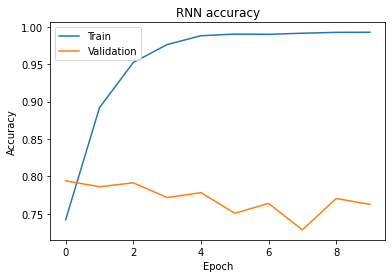

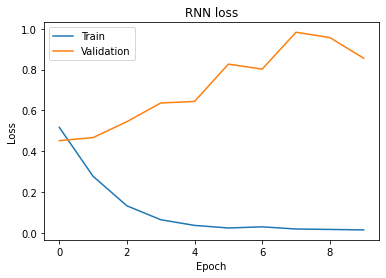

In [ ]:
# Plotar métricas
plot_graphs(rnn_history,"RNN")

### **Modelo 2:** Redes Recorrentes usando Pooling

In [ ]:
def RNN_pooling(max_words = max_words, max_len = X.shape[1]):
  ''' Função que constrói modelo RNN com pooling. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=50)(inputs)
  layer = Bidirectional(LSTM(lstm_out, return_sequences=True, name='LSTM'))(layer)
  avg_pool = GlobalAveragePooling1D()(layer)
  max_pool = GlobalMaxPooling1D()(layer)
  conc = concatenate([avg_pool, max_pool])
  layer = Dense(1,name='out_layer')(conc)
  layer = Activation('sigmoid')(layer)
  model_pooling = Model(inputs=inputs,outputs=layer)
  return model_pooling

In [ ]:
# Construir e compilar modelo
RNN_pooling = RNN_pooling()
RNN_pooling.summary()
RNN_pooling.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      6000000     inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      439296      embedding_2[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 256)          0           bidirectional_1[0][0]            
_______________________________________________________________________________________

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_RNN_pool.h5', save_best_only=True)]
RNN_pooling_history = RNN_pooling.fit(X,Y,batch_size=32,epochs=10, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_RNN_pool.h5'):
    RNN_pooling = load_model('./Modelos/best_model_RNN_pool.h5')

Epoch 1/10
215/215 [==============================] - 16s 73ms/step - loss: 0.5120 - accuracy: 0.7546 - val_loss: 0.4390 - val_accuracy: 0.7979
Epoch 2/10
215/215 [==============================] - 14s 67ms/step - loss: 0.2601 - accuracy: 0.8997 - val_loss: 0.4949 - val_accuracy: 0.7874
Epoch 3/10
215/215 [==============================] - 14s 66ms/step - loss: 0.1218 - accuracy: 0.9580 - val_loss: 0.5992 - val_accuracy: 0.7730
Epoch 4/10
215/215 [==============================] - 14s 65ms/step - loss: 0.0647 - accuracy: 0.9794 - val_loss: 0.7325 - val_accuracy: 0.7546
Epoch 5/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.8095 - val_accuracy: 0.7598
Epoch 6/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0216 - accuracy: 0.9918 - val_loss: 0.9187 - val_accuracy: 0.7625
Epoch 7/10
215/215 [==============================] - 14s 64ms/step - loss: 0.0168 - accuracy: 0.9923 - val_loss: 1.0411 - val_accuracy:

In [ ]:
# Plotar métricas
plot_graphs(RNN_pooling_history, "RNN Pooling")

### **Modelo 3:** Redes Recorrentes usando GloVe

*Global Vectors for Word Representation*, ou GloVe, é um algoritmo de aprendizado não-supervisionado com o objetivo de obter representações vetoriais para palavras, proposto em 2014. O algoritmo mapeia as palavras no espaço, tal que a distância e a semelhança semântica entre elas é proporcional.

Utilizamos sua representação de palavras para nosso conjunto de dados e seus pesos pré-treinados na camada de Embedding da rede, mais especificamente o arquivo *glove.840B.300d.txt*.

In [ ]:
# Preparar incorporação de palavras
import numpy as np
embeddings_index = dict()
f = open('../Glove/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
      float(values[1])
    except ValueError:
      continue
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Construir matriz de incorporação
embedding_matrix = np.zeros((max_words, 300))
for word, index in tokenizer.word_index.items():
    if index > max_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
def RNN_glove(max_words = max_words, max_len = X.shape[1]):
  ''' Função que constrói modelo RNN usando Glove. '''
  
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=50, weights=[embedding_matrix], trainable=False)(inputs)
  layer = Bidirectional(LSTM(lstm_out, return_sequences=True, name='LSTM'))(layer)
  avg_pool = GlobalAveragePooling1D()(layer)
  max_pool = GlobalMaxPooling1D()(layer)
  conc = concatenate([avg_pool, max_pool])
  layer = Dense(1,name='out_layer')(conc)
  layer = Activation('sigmoid')(layer)
  model_glove = Model(inputs=inputs,outputs=layer)
  return model_glove

In [ ]:
# Construir e compilar modelo
RNN_glove = RNN_glove()
RNN_glove.summary()
RNN_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      6000000     inputs[0][0]                     
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 256)      439296      embedding_1[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           bidirectional_2[0][0]            
_______________________________________________________________________________________

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_RNN_glove.h5', save_best_only=True)]
RNN_glove_history = RNN_glove.fit(X,Y,batch_size=32,epochs=10, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_RNN_glove.h5'):
    RNN_glove = load_model('./Modelos/best_model_RNN_glove.h5')

Epoch 1/10
215/215 [==============================] - 8s 38ms/step - loss: 0.4554 - accuracy: 0.7948 - val_loss: 0.4317 - val_accuracy: 0.8071
Epoch 2/10
215/215 [==============================] - 7s 33ms/step - loss: 0.3884 - accuracy: 0.8310 - val_loss: 0.4364 - val_accuracy: 0.7979
Epoch 3/10
215/215 [==============================] - 8s 36ms/step - loss: 0.3572 - accuracy: 0.8494 - val_loss: 0.4304 - val_accuracy: 0.8058
Epoch 4/10
215/215 [==============================] - 7s 33ms/step - loss: 0.3207 - accuracy: 0.8626 - val_loss: 0.4539 - val_accuracy: 0.7953
Epoch 5/10
215/215 [==============================] - 7s 33ms/step - loss: 0.2800 - accuracy: 0.8898 - val_loss: 0.4792 - val_accuracy: 0.7795
Epoch 6/10
215/215 [==============================] - 7s 33ms/step - loss: 0.2390 - accuracy: 0.9048 - val_loss: 0.5000 - val_accuracy: 0.7979
Epoch 7/10
215/215 [==============================] - 7s 33ms/step - loss: 0.1957 - accuracy: 0.9279 - val_loss: 0.5173 - val_accuracy: 0.7769

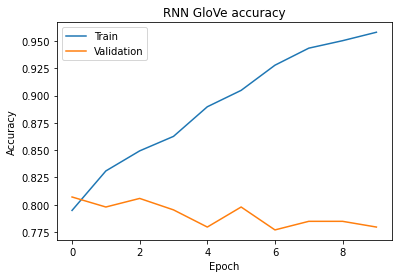

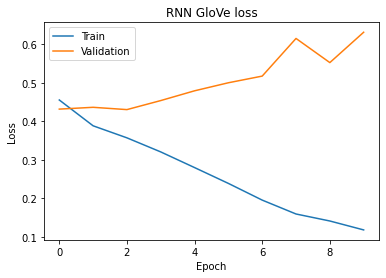

In [ ]:
# Plotar métricas
plot_graphs(RNN_glove_history, "RNN GloVe")